<a href="https://colab.research.google.com/github/nikitavlasov2003/Trassers/blob/main/Trassers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.3 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.1 MB/s eta 0:00:00


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Загрузка таблиц
df_params = pd.read_excel('/content/dataset1.xlsx')                     # параметры добывающих скважин
df_output = pd.read_excel('/content/dataset2.xlsx')           # выход индикатора
df_volume = pd.read_excel('/content/dataset3.xlsx')            # объемные характеристики # в characteristics неверный датасет!
df_speed = pd.read_excel('/content/dataset4.xlsx')        # скорости фильтрации
df_perm = pd.read_excel('/content/dataset5.xlsx')                 # проницаемость
df_area = pd.read_excel('/content/dataset6.xlsx')         # сечения
df_impact = pd.read_excel('/content/dataset7.xlsx')        # влияние нагнетательной скважины

In [ ]:
# Шаг 1: merge параметров и выхода индикатора
df_merged = df_params.merge(df_output, on=['Number_expl_well', 'Id _pump_well'], how='left') \
                .merge(df_volume, on=['Number_expl_well', 'Id _pump_well'], how='left') \
                .merge(df_speed, on=['Number_expl_well', 'Id _pump_well'], how='left') \
                .merge(df_perm, on=['Number_expl_well', 'Id _pump_well'], how='left') \
                .merge(df_area, on=['Number_expl_well', 'Id _pump_well'], how='left') \
                .merge(df_impact, on=['Number_expl_well', 'Id _pump_well'], how='left')
df_merged.head()

,Number_expl_well,"Дебит жидкости, м3/сут","Дебит нефти, м3/сут","Обводненность, %",Id _pump_well,hours,"Масса вынесенного трассера, кг",Выход индикатора в % относительно массы закачки,Выход индикатора в % относительно отобранной массы,"Производит-ть проницаемой системы, м3/сут",...,"Средняя скорость фильтрации, м/сут","Min. фактическая проницаемость, кв. мкм (Д)","Max. фактическая проницаемость, кв. мкм (Д)","Средняя приведенная проницаемость, кв. мкм (Д)","Гидропроводность установленных каналов фильтрации, Д*см/сП","Объем породы, м3","Площадь сечения условного канала (системы каналов), м2",Обводненность на декабрь 2022 года,"Степень влияния наг. воды на обводненность, %",классификация
0,2,74.26,16.34,78,361,118.0,20.857,4.17,4.98,7.631,...,72.79,30.21,1294.42,223.59,1465,212.02,0.10,12.26,78,2
1,31,23.25,22.78,2,361,0.0,0.000,0.00,0.00,0.000,...,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,2,0
2,58,55.64,18.92,66,361,68.0,3.865,0.77,0.92,1.489,...,4.57,0.84,50.25,2.25,78,98.76,0.33,4.44,66,1
3,187,26.11,21.15,19,361,99.0,1.014,0.20,0.24,0.408,...,24.60,21.69,1084.12,61.12,306,30.39,0.02,10.06,19,2
4,188,338.40,47.38,86,361,21.0,54.748,10.95,13.08,20.051,...,88.23,39.27,10020.58,334.33,3709,521.92,0.23,7.07,86,2


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 26 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Number_expl_well                                                       408 non-null    int64  
 1   Дебит жидкости, м3/сут                                                 408 non-null    float64
 2   Дебит нефти, м3/сут                                                    408 non-null    float64
 3   Обводненность, %                                                       408 non-null    int64  
 4   Id _pump_well                                                          408 non-null    int64  
 5   hours                                                                  399 non-null    float64
 6   Масса вынесенного трассера, кг                                         408 non-null    flo

In [ ]:
df_merged = df_merged.dropna() # черновой вариант

In [ ]:
df = df_merged.rename(columns={
    'Number_expl_well': 'well_num',
    'Дебит жидкости, м3/сут': 'debit_liq',
    'Дебит нефти, м3/сут': 'debit_oil',
    'Обводненность, %': 'watercut',
    'Id _pump_well': 'inj_well_id',
    'hours': 'hours',
    'Масса вынесенного трассера, кг': 'tracer_mass_out',
    'Выход индикатора в % относительно массы закачки': 'tracer_out_perct_pump_mass',
    'Выход индикатора в % относительно отобранной массы': 'tracer_out_perct_select_mass',
    'Производит-ть проницаемой системы, м3/сут': 'perm_sys_prod_rate',
    'Количество закачанного индикатора, кг': 'tracer_mass_in',
    'Суммарное количество трассера, вышедшего на дневную поверхность': 'tracer_total_out',
    'Суммарная производительность всей проницаемой системы скважин  м3/сут': 'total_perm_sys_prod_rate',
    'Минимальное расстояние до нагнетательной скважины, м': 'min_dist_to_inj',
    'Минимальная скорость фильтрации, м/сут': 'min_filtration_rate',
    'Максимальная скорость фильтрации, м/сут': 'max_filtration_rate',
    'Средняя скорость фильтрации, м/сут': 'avg_filtration_rate',
    'Min. фактическая проницаемость, кв. мкм (Д)': 'perm_min',
    'Max. фактическая проницаемость, кв. мкм (Д)': 'perm_max',
    'Средняя приведенная проницаемость, кв. мкм (Д)': 'perm_avg_adj',
    'Гидропроводность установленных каналов фильтрации, Д*см/сП': 'hydroconductivity',
    'Объем породы, м3': 'rock_volume',
    'Площадь сечения условного канала (системы каналов), м2': 'cross_section_area',
    'Обводненность на декабрь 2022 года': 'watercut_dec',
    'Степень влияния наг. воды на обводненность, %': 'water_inj_impact_pct',
    'классификация': 'class'
})

In [ ]:
df = df.drop('watercut_dec', axis = 1)
df.head()

,well_num,debit_liq,debit_oil,watercut,inj_well_id,hours,tracer_mass_out,tracer_out_perct_pump_mass,tracer_out_perct_select_mass,perm_sys_prod_rate,...,max_filtration_rate,avg_filtration_rate,perm_min,perm_max,perm_avg_adj,hydroconductivity,rock_volume,cross_section_area,water_inj_impact_pct,class
0,2,74.26,16.34,78,361,118.0,20.857,4.17,4.98,7.631,...,413.09,72.79,30.21,1294.42,223.59,1465,212.02,0.10,78,2
1,31,23.25,22.78,2,361,0.0,0.000,0.00,0.00,0.000,...,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,2,0
2,58,55.64,18.92,66,361,68.0,3.865,0.77,0.92,1.489,...,106.92,4.57,0.84,50.25,2.25,78,98.76,0.33,66,1
3,187,26.11,21.15,19,361,99.0,1.014,0.20,0.24,0.408,...,446.08,24.60,21.69,1084.12,61.12,306,30.39,0.02,19,2
4,188,338.40,47.38,86,361,21.0,54.748,10.95,13.08,20.051,...,2656.36,88.23,39.27,10020.58,334.33,3709,521.92,0.23,86,2


In [ ]:
df[df['hours'] == -1]

,well_num,debit_liq,debit_oil,watercut,inj_well_id,hours,tracer_mass_out,tracer_out_perct_pump_mass,tracer_out_perct_select_mass,perm_sys_prod_rate,...,max_filtration_rate,avg_filtration_rate,perm_min,perm_max,perm_avg_adj,hydroconductivity,rock_volume,cross_section_area,water_inj_impact_pct,class
386,412,1074.73,53.74,95,1471,-1.0,67.992,16.998,38.563,37.499,...,78.51,31.13,1.84,71.38,28.12,759,679.4,1.205,4,1


In [ ]:
df = df.drop(labels = [386], axis = 0)

**EDA (exploratory data analysis)**

In [ ]:
# общая характеристика
df.describe()

,well_num,debit_liq,debit_oil,watercut,inj_well_id,hours,tracer_mass_out,tracer_out_perct_pump_mass,tracer_out_perct_select_mass,perm_sys_prod_rate,...,max_filtration_rate,avg_filtration_rate,perm_min,perm_max,perm_avg_adj,hydroconductivity,rock_volume,cross_section_area,water_inj_impact_pct,class
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,1155.879397,213.563593,41.837387,54.540201,381.231156,442.994975,5.077930,1.675566,2.344896,2.916075,...,412.049548,19.456884,31.953819,1347.912789,53.787236,353.776382,257.815352,0.429237,7.135678,0.540201
std,1339.776625,254.950469,22.440181,32.085797,206.144521,971.586181,12.579208,3.580236,4.622031,5.603502,...,695.195869,36.106202,86.460504,3192.271740,128.971389,596.664796,586.984898,1.488851,19.413612,0.704174
min,2.000000,15.590000,4.630000,1.000000,280.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.000000,46.530000,22.780000,23.000000,307.000000,18.000000,0.014462,0.030250,0.032500,0.045125,...,12.840000,2.280000,0.850000,9.990000,1.482500,15.000000,1.796500,0.001350,0.000000,0.000000
50%,418.000000,105.720000,39.710000,53.000000,334.000000,74.500000,0.233500,0.284500,0.460000,0.563250,...,76.655000,7.785000,8.540000,114.695000,14.090000,85.500000,35.850000,0.041000,1.000000,0.000000
75%,1362.000000,249.380000,49.990000,86.000000,363.000000,447.250000,2.299500,1.341750,2.422500,2.870325,...,470.397500,21.002500,30.257500,975.932500,53.327500,384.500000,205.505000,0.227500,2.000000,1.000000
max,4435.000000,1074.730000,103.870000,97.000000,1471.000000,6622.000000,129.512000,32.760000,36.630000,37.560000,...,3385.990000,399.890000,1224.710000,27109.170000,1677.640000,3769.000000,5196.816000,14.330000,97.000000,3.000000


In [ ]:
# пропуски
df.isnull().sum()

,0
well_num,0
debit_liq,0
debit_oil,0
watercut,0
inj_well_id,0
hours,0
tracer_mass_out,0
tracer_out_perct_pump_mass,0
tracer_out_perct_select_mass,0
perm_sys_prod_rate,0


Text(0.5, 1.0, 'Корреляция признаков')

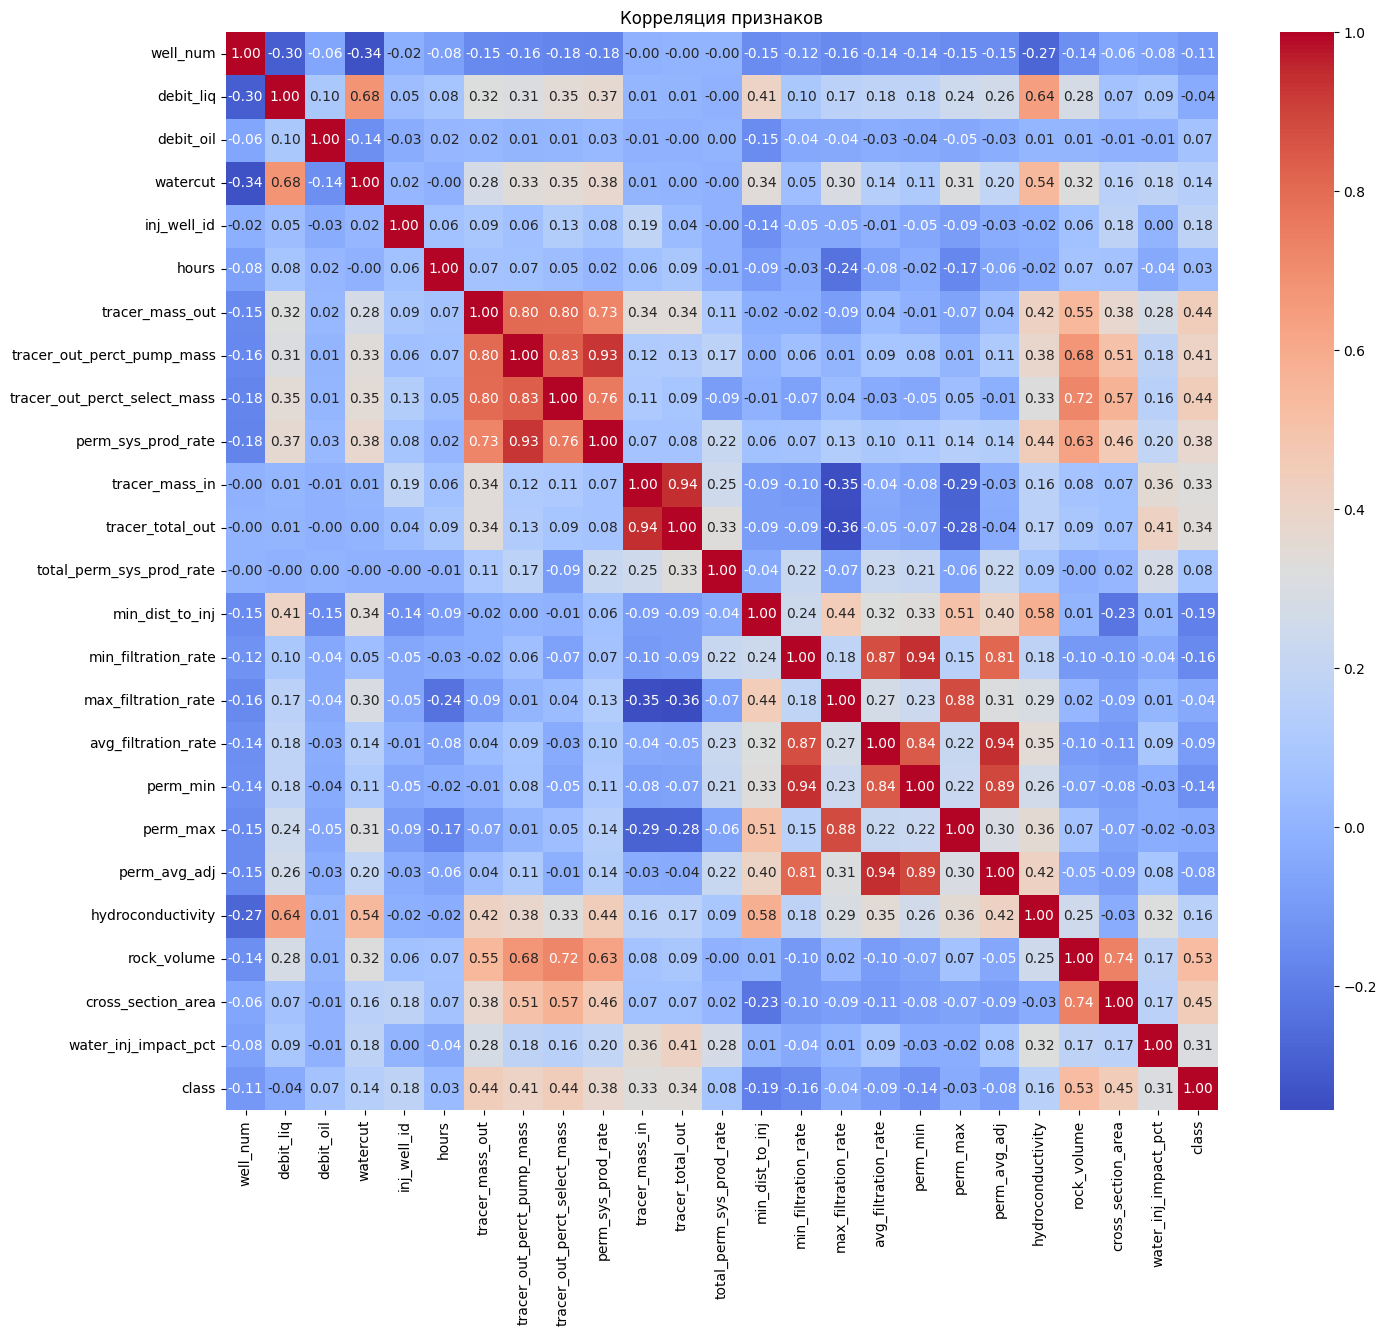

In [ ]:
# Корреляционная матрица
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df.corr(numeric_only = True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot = True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция признаков")

In [ ]:
# Посмотрим пары признаков с высокой корреляцией
high_corr_pairs = []
threshold = 0.8
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))
for pair in high_corr_pairs:
    print(f"{pair[0]} ↔ {pair[1]}: corr = {pair[2]:.2f}")

tracer_mass_out ↔ tracer_out_perct_pump_mass: corr = 0.80
tracer_mass_out ↔ tracer_out_perct_select_mass: corr = 0.80
tracer_out_perct_pump_mass ↔ tracer_out_perct_select_mass: corr = 0.83
tracer_out_perct_pump_mass ↔ perm_sys_prod_rate: corr = 0.93
tracer_mass_in ↔ tracer_total_out: corr = 0.94
min_filtration_rate ↔ avg_filtration_rate: corr = 0.87
min_filtration_rate ↔ perm_min: corr = 0.94
min_filtration_rate ↔ perm_avg_adj: corr = 0.81
max_filtration_rate ↔ perm_max: corr = 0.88
avg_filtration_rate ↔ perm_min: corr = 0.84
avg_filtration_rate ↔ perm_avg_adj: corr = 0.94
perm_min ↔ perm_avg_adj: corr = 0.89


In [ ]:
cols_to_drop = [
    'tracer_out_perct_pump_mass',
    'tracer_out_perct_select_mass',
    'tracer_mass_in',
    'min_filtration_rate',
    'max_filtration_rate',
    'perm_min',
    'perm_avg_adj'
]
df = df.drop(columns=cols_to_drop, errors='ignore')
df = df.drop(columns=['perm_avg_adj'], errors='ignore')

Text(0.5, 1.0, 'Корреляция признаков')

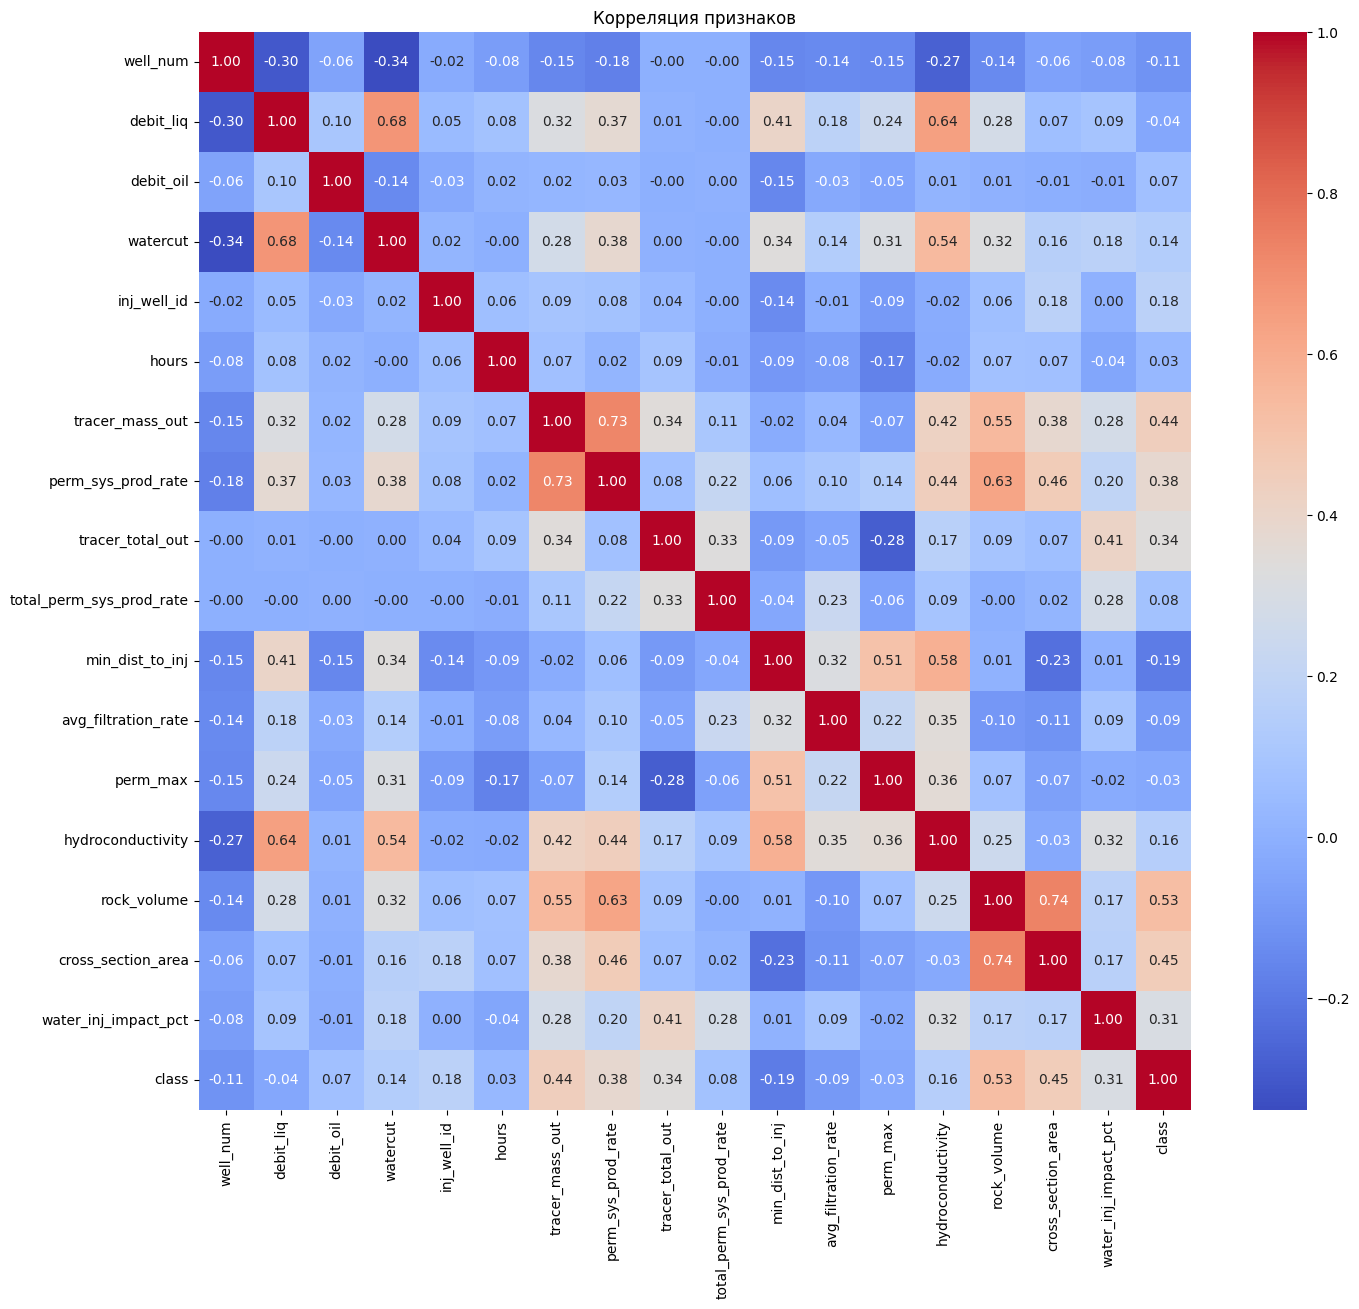

In [ ]:
corr_matrix = df.corr(numeric_only = True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot = True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция признаков")

**Feature engeenering**

In [ ]:
#Добавление новых категориальных признаков

# 1. Категория по времени прорыва
def categorize_hours(hours):
    if 0 < hours <= 120:  # до 5 суток
        return 0  # короткое время
    elif 120 < hours <= 600:  # от 5 до 25 суток
        return 1  # среднее время
    else:
        return 2  # долгое время

df['breakthrough_time_cat'] = df['hours'].apply(categorize_hours)
# чем меньше, тем лучше

# 2. Категория по массе вынесенного трассера (исключаем нули из расчёта среднего)
mean_tracer_mass = df.loc[df['tracer_mass_out'] > 0, 'tracer_mass_out'].mean()
df['high_tracer_output'] = (df['tracer_mass_out'] < mean_tracer_mass).astype(int)

# 3. Категория по производительности проницаемой системы (через фильтрацию, исключая 0)
mean_filtration = df.loc[df['perm_sys_prod_rate'] > 0, 'perm_sys_prod_rate'].mean()
df['strong_hydro_conn'] = (df['perm_sys_prod_rate'] < mean_filtration).astype(int)

In [ ]:
def map_impact(rate):
    if rate >= 2:
        return 0
    else:
        return 1
df['cat_watercut'] = df['class'].apply(map_impact)
# 0 - max влияние
# 1 - min влияение

In [ ]:
def filtration_level(level):
    if level >50:
        return 0 # высокий
    elif 20 < level < 50:
        return 1 # средний
    else:
        return 2 # низкий

df['cat_speed'] = df['avg_filtration_rate'].apply(filtration_level)

In [ ]:
def rock_volume_cat(vol):
    if vol < 200:
        return 1 # это малый объем - плохо
    else:
        return 0 # это хороший объем
df['cat_volume'] = df['rock_volume'].apply(rock_volume_cat)

In [ ]:
def cs_area_cat(area):
    if area < 0.05:
        return 1 # это малая площадь - плохо
    else:
        return 0 # это неплохая площадь
df['cat_area'] = df['cross_section_area'].apply(cs_area_cat)

In [ ]:
df = df.drop('class', axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 0 to 399
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   well_num                  398 non-null    int64  
 1   debit_liq                 398 non-null    float64
 2   debit_oil                 398 non-null    float64
 3   watercut                  398 non-null    int64  
 4   inj_well_id               398 non-null    int64  
 5   hours                     398 non-null    float64
 6   tracer_mass_out           398 non-null    float64
 7   perm_sys_prod_rate        398 non-null    float64
 8   tracer_total_out          398 non-null    float64
 9   total_perm_sys_prod_rate  398 non-null    float64
 10  min_dist_to_inj           398 non-null    float64
 11  avg_filtration_rate       398 non-null    float64
 12  perm_max                  398 non-null    float64
 13  hydroconductivity         398 non-null    int64  
 14  rock_volume    

In [ ]:
df['effect_score'] = df[['breakthrough_time_cat', 'high_tracer_output', 'strong_hydro_conn', 'cat_watercut', 'cat_speed','cat_volume','cat_area']].sum(axis=1)
def map_effect(score):
    if score <= 2:
        return 1
    elif 3<= score <=5:
        return 0
    else:
        return -1
df['effect'] = df['effect_score'].apply(map_effect)

In [ ]:
df.head()

,well_num,debit_liq,debit_oil,watercut,inj_well_id,hours,tracer_mass_out,perm_sys_prod_rate,tracer_total_out,total_perm_sys_prod_rate,...,water_inj_impact_pct,breakthrough_time_cat,high_tracer_output,strong_hydro_conn,cat_watercut,cat_speed,cat_volume,cat_area,effect_score,effect
0,2,74.26,16.34,78,361,118.0,20.857,7.631,418.481,159.89,...,78,0,0,0,0,0,0,0,0,1
1,31,23.25,22.78,2,361,0.0,0.000,0.000,418.481,159.89,...,2,2,1,1,1,2,1,1,9,-1
2,58,55.64,18.92,66,361,68.0,3.865,1.489,418.481,159.89,...,66,0,1,1,1,2,1,0,6,-1
3,187,26.11,21.15,19,361,99.0,1.014,0.408,418.481,159.89,...,19,0,1,1,0,1,1,1,5,0
4,188,338.40,47.38,86,361,21.0,54.748,20.051,418.481,159.89,...,86,0,0,0,0,0,0,0,0,1


Text(0.5, 1.0, 'Корреляция признаков')

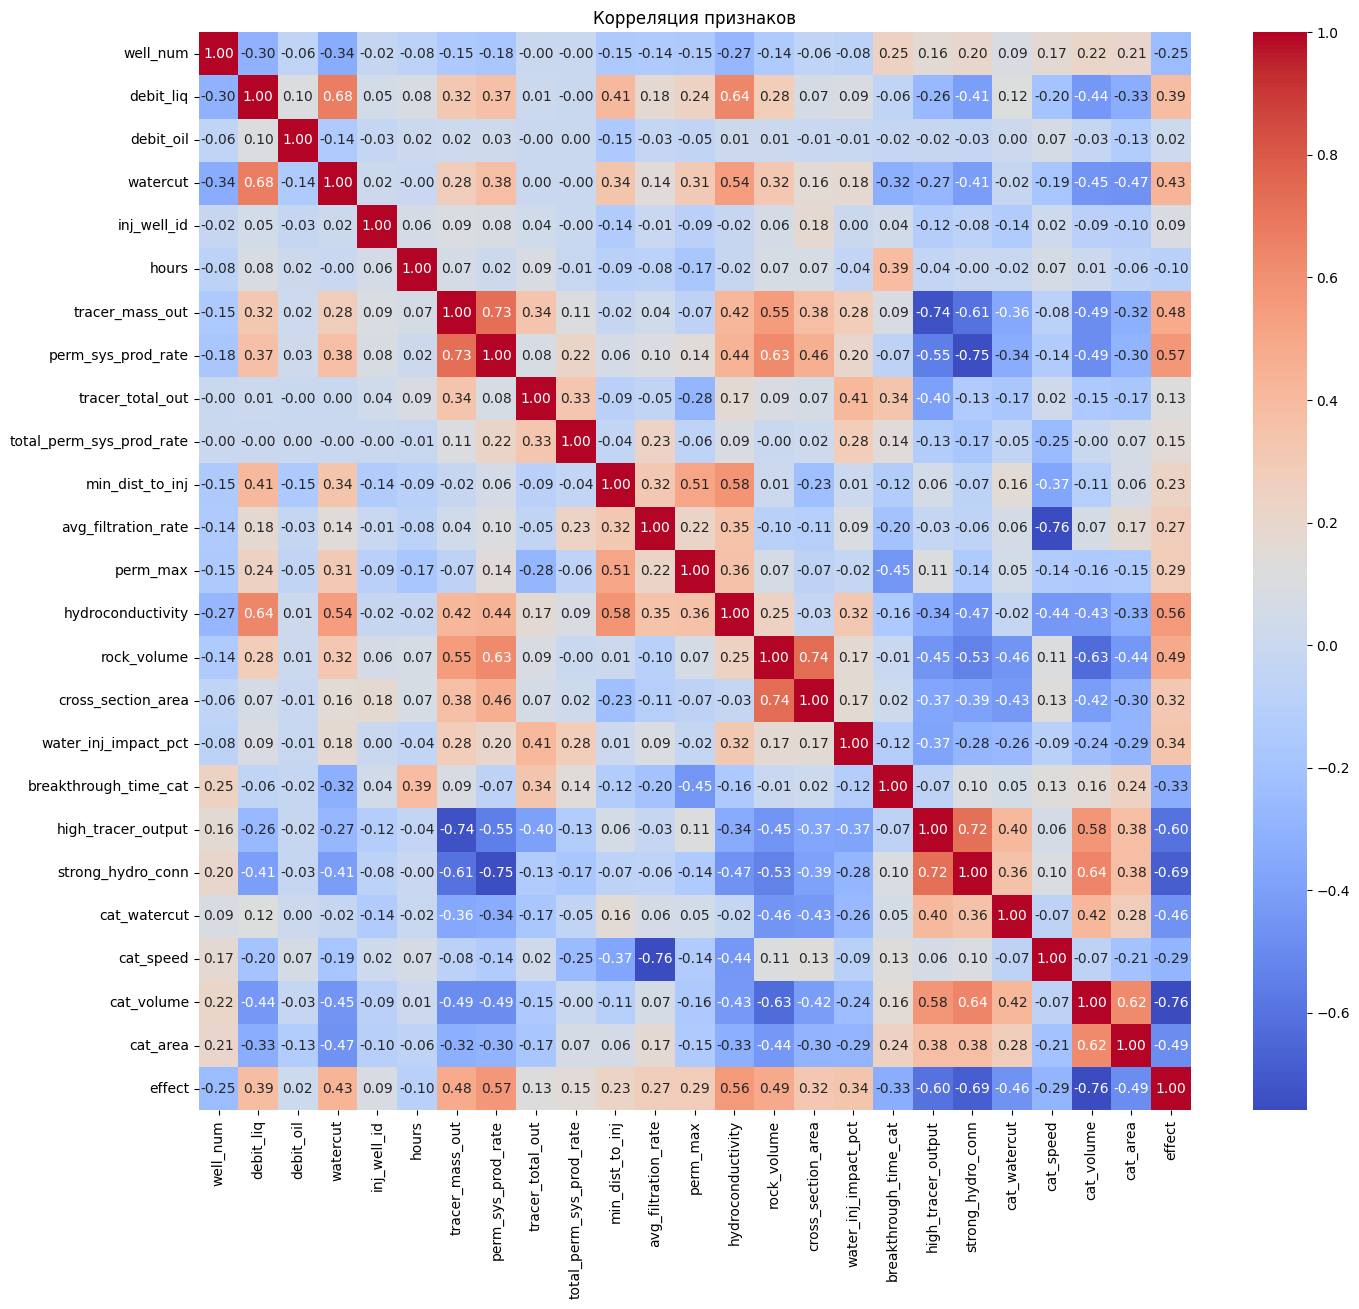

In [ ]:
df1 = df.drop('effect_score', axis = 1)
corr_matrix = df1.corr(numeric_only = True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot = True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция признаков")

**Построение модели**

In [ ]:
import optuna
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Разделение на признаки и цель
X = df.drop(['effect', 'effect_score', 'well_num', 'inj_well_id'], axis = 1)
y = df['effect']

In [ ]:
# Категориальные признаки
cat_features = ['breakthrough_time_cat', 'high_tracer_output', 'strong_hydro_conn',
                'cat_watercut', 'cat_speed', 'cat_volume', 'cat_area']

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train, cat_features=cat_features)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.96      0.96        53
           0       0.92      0.92      0.92        25
           1       1.00      1.00      1.00         2

    accuracy                           0.95        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.95      0.95      0.95        80



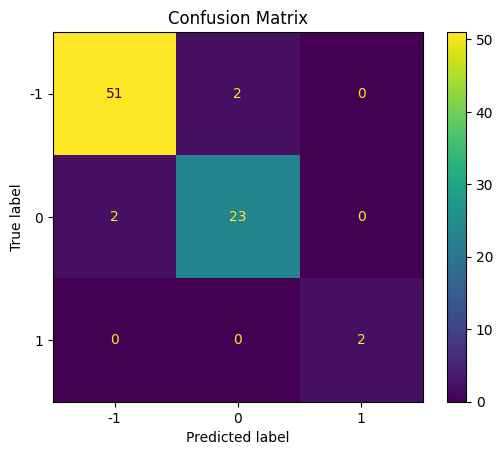

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=[-1, 0, 1])
plt.title("Confusion Matrix")
plt.show()

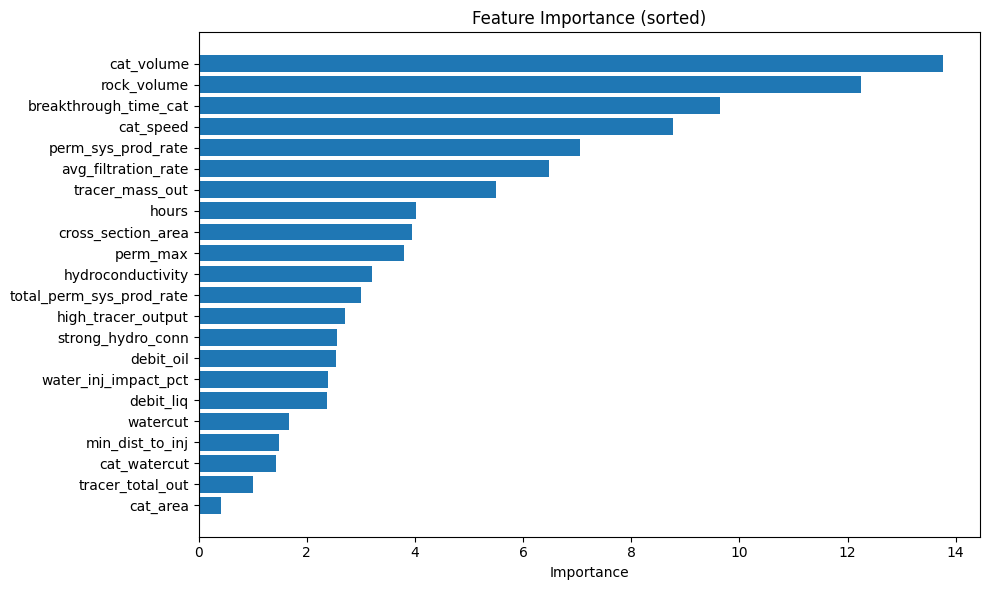

In [ ]:
# Получаем важности и названия признаков
importances = model.get_feature_importance()
feature_names = X.columns

# Сортировка по убыванию
sorted_idx = np.argsort(importances)

# Построение отсортированной диаграммы
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance (sorted)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
df['predicted_effect'] = model.predict(df[X.columns])
candidates = df[df['predicted_effect'] == 1]
maybe = df[df['predicted_effect'] == 0]
not_recommended = df[df['predicted_effect'] == -1]
cols_to_show = ['inj_well_id','well_num', 'predicted_effect', 'cat_volume', 'rock_volume', 'breakthrough_time_cat', 'cat_speed', 'perm_sys_prod_rate', 'avg_filtration_rate', 'tracer_mass_out']
df.loc[df['predicted_effect'] == 1, cols_to_show]

,inj_well_id,well_num,predicted_effect,cat_volume,rock_volume,breakthrough_time_cat,cat_speed,perm_sys_prod_rate,avg_filtration_rate,tracer_mass_out
0,361,2,1,0,212.020,0,0,7.6310,72.79,20.857
4,361,188,1,0,521.920,0,0,20.0510,88.23,54.748
6,361,231,1,0,459.790,1,0,15.8750,91.70,43.368
7,361,252,1,0,308.340,0,0,19.0890,110.25,52.591
22,361,445,1,0,212.790,0,1,4.8820,22.54,13.397
26,361,1307,1,0,1160.020,0,2,6.1030,4.40,15.246
28,361,1334,1,0,2076.540,0,2,8.9090,2.16,21.674
73,333,1448,1,0,928.059,0,2,4.6443,3.64,6.228
133,363,279,1,0,568.680,0,2,16.4179,3.03,47.854
392,1471,594,1,0,217.170,0,1,7.9900,48.67,14.485


In [ ]:
# Объяснитель для CatBoost
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

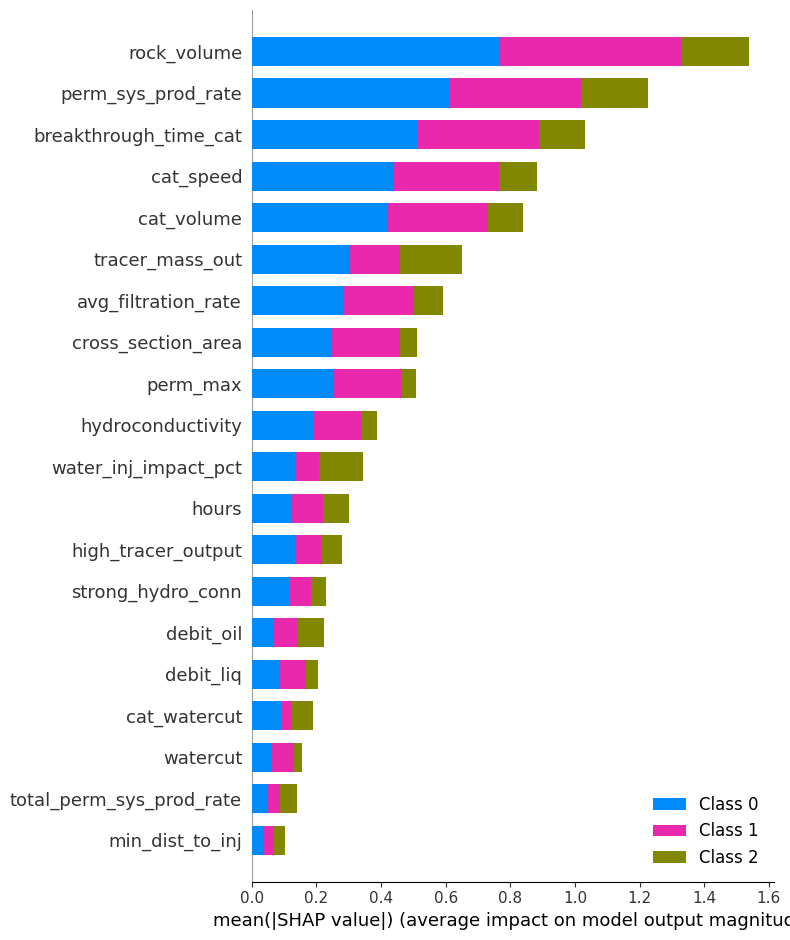

In [ ]:
# Глобальный summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
model.classes_

array([-1,  0,  1])

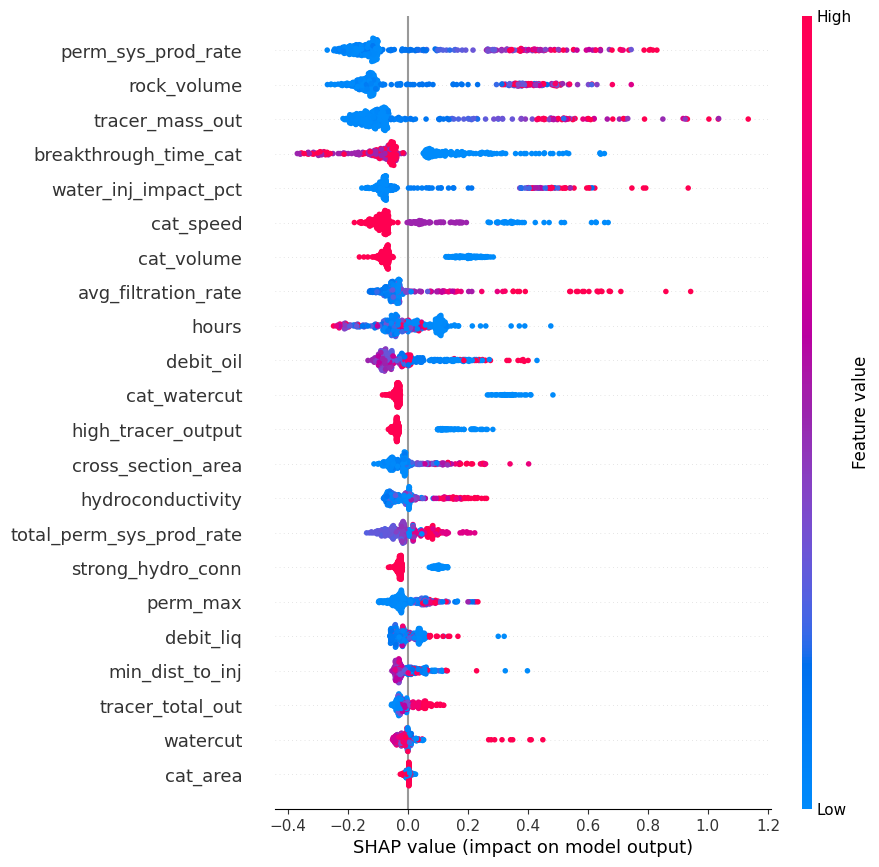

In [ ]:
# 1. Создаем объяснитель
explainer = shap.TreeExplainer(model)
# 2. Получаем SHAP значения как Explanation объект
shap_values = explainer(X)
# 3. Beeswarm для всех классов
shap.plots.beeswarm(shap_values[..., 2], max_display = 22)  # Класс 1 (эффективный)

Update

**1. OPTUNA**

In [ ]:
# Разделение на признаки и цель
X = df.drop(['effect', 'effect_score', 'well_num', 'inj_well_id'], axis = 1)
y = df['effect']

In [ ]:
# Категориальные признаки
cat_features = ['breakthrough_time_cat', 'high_tracer_output', 'strong_hydro_conn',
                'cat_watercut', 'cat_speed', 'cat_volume', 'cat_area']

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Функция для Optuna
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 500),
        "random_state": 42,
        "verbose": 0,
        "cat_features": cat_features
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X, y, scoring="f1_macro", cv=cv).mean()
    return score

In [ ]:
# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-04-20 15:29:49,207] A new study created in memory with name: no-name-d7e94b4d-8a84-403f-8f88-a70cb0ca71f2
[I 2025-04-20 15:29:53,868] Trial 0 finished with value: 0.9900993048824043 and parameters: {'learning_rate': 0.16724515466042483, 'max_depth': 4, 'l2_leaf_reg': 7.242840764761972, 'iterations': 263}. Best is trial 0 with value: 0.9900993048824043.
[I 2025-04-20 15:30:01,870] Trial 1 finished with value: 0.9881460517862941 and parameters: {'learning_rate': 0.20251921984377916, 'max_depth': 4, 'l2_leaf_reg': 7.686774226914909, 'iterations': 349}. Best is trial 0 with value: 0.9900993048824043.
[I 2025-04-20 15:30:52,457] Trial 2 finished with value: 0.9881460517862941 and parameters: {'learning_rate': 0.11183490865600763, 'max_depth': 8, 'l2_leaf_reg': 2.9862479141043003, 'iterations': 342}. Best is trial 0 with value: 0.9900993048824043.
[I 2025-04-20 15:31:37,408] Trial 3 finished with value: 0.9920947697350119 and parameters: {'learning_rate': 0.02733353155917772, 'max_de

In [ ]:
# Вывод лучших параметров
print("Best parameters:", study.best_trial.params)

Best parameters: {'learning_rate': 0.2600045321879627, 'max_depth': 8, 'l2_leaf_reg': 3.354678140269451, 'iterations': 107}


In [ ]:
# Финальное обучение на лучших параметрах
final_model = CatBoostClassifier(
    **study.best_trial.params,
    cat_features=cat_features,
    random_state=42,
    verbose=0
)
final_model.fit(X_train, y_train)

In [ ]:
# Оценка на тестовой выборке
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.96      0.96        53
           0       0.92      0.92      0.92        25
           1       1.00      1.00      1.00         2

    accuracy                           0.95        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.95      0.95      0.95        80



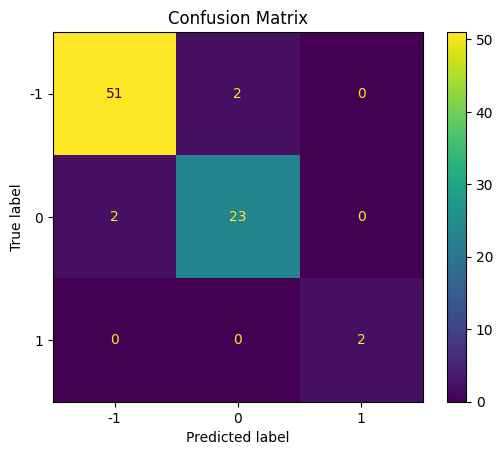

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=[-1, 0, 1])
plt.title("Confusion Matrix")
plt.show()

**2. OPTUNA + SMOTE**

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Разделение на признаки и цель
X = df.drop(['effect', 'effect_score', 'well_num', 'inj_well_id'], axis = 1)
y = df['effect']

In [ ]:
# Категориальные признаки
cat_features = ['breakthrough_time_cat', 'high_tracer_output', 'strong_hydro_conn',
                'cat_watercut', 'cat_speed', 'cat_volume', 'cat_area']

In [ ]:
# Кодируем y для SMOTE
le = LabelEncoder()
y_enc = le.fit_transform(y)

# SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
y_res_decoded = le.inverse_transform(y_res)

In [ ]:
# Проверяем баланс классов после SMOTE
print("Классы после SMOTE:\n", pd.Series(y_res).value_counts())

Классы после SMOTE:
 2    264
0    264
1    264
Name: count, dtype: int64


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res_decoded, stratify=y_res_decoded, test_size=0.2, random_state=42)

In [ ]:
# Optuna
def objective(trial):
    # Разделение вручную внутри objective — можно даже с другими random_state
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Подбор параметров
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 500),
        "random_state": 42,
        "verbose": 0,
        "cat_features": cat_features
    }

    # Обучение модели
    model = CatBoostClassifier(**params)
    model.fit(
        X_train_split, y_train_split,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=0
    )

    # Предсказания
    y_pred = model.predict(X_val)

    # Метрика — F1 по всем классам
    return f1_score(y_val, y_pred, average='macro')

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-04-20 15:39:59,552] A new study created in memory with name: no-name-7a14873b-52b0-40e9-91bd-5f19a2617b63
[I 2025-04-20 15:40:02,717] Trial 0 finished with value: 0.960754716981132 and parameters: {'learning_rate': 0.09253716233535532, 'max_depth': 8, 'l2_leaf_reg': 3.222160190400313, 'iterations': 408}. Best is trial 0 with value: 0.960754716981132.
[I 2025-04-20 15:40:04,517] Trial 1 finished with value: 0.960754716981132 and parameters: {'learning_rate': 0.14015496123534138, 'max_depth': 8, 'l2_leaf_reg': 2.040737942297839, 'iterations': 166}. Best is trial 0 with value: 0.960754716981132.
[I 2025-04-20 15:40:04,830] Trial 2 finished with value: 0.960754716981132 and parameters: {'learning_rate': 0.2564498988674884, 'max_depth': 4, 'l2_leaf_reg': 8.976897486091566, 'iterations': 444}. Best is trial 0 with value: 0.960754716981132.
[I 2025-04-20 15:40:06,119] Trial 3 finished with value: 0.960754716981132 and parameters: {'learning_rate': 0.0708810292869528, 'max_depth': 7, '

In [ ]:
# Лучшие параметры
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'learning_rate': 0.09253716233535532, 'max_depth': 8, 'l2_leaf_reg': 3.222160190400313, 'iterations': 408}


In [ ]:
# Обучим модель с лучшими параметрами
best_model = CatBoostClassifier(**study.best_trial.params, random_state=115, verbose=0)
best_model.fit(X_train, y_train, cat_features=cat_features)


In [ ]:
# Оценка
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.96      0.98        53
           0       0.96      1.00      0.98        53
           1       1.00      1.00      1.00        53

    accuracy                           0.99       159
   macro avg       0.99      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159



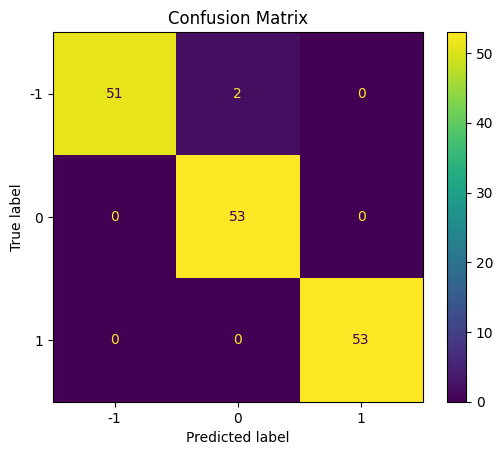

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=[-1, 0, 1])
plt.title("Confusion Matrix")
plt.show()

**3. CLASS WEIGHTS**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Разделение на признаки и цель
X = df.drop(['effect', 'effect_score', 'well_num', 'inj_well_id'], axis = 1)
y = df['effect']

In [ ]:
# Категориальные признаки
cat_features = ['breakthrough_time_cat', 'high_tracer_output', 'strong_hydro_conn',
                'cat_watercut', 'cat_speed', 'cat_volume', 'cat_area']

In [ ]:
# Веса классов
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

Class Weights: {np.int64(-1): np.float64(0.5025252525252525), np.int64(0): np.float64(1.0698924731182795), np.int64(1): np.float64(13.266666666666667)}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Финальное обучение
final_model = CatBoostClassifier(
    learning_rate=0.1,
    max_depth=6,
    iterations=300,
    cat_features=cat_features,
    class_weights=class_weights,
    random_state=42,
    verbose=100
)
final_model.fit(X_train, y_train)

0:	learn: 0.9533315	total: 9.24ms	remaining: 2.76s
100:	learn: 0.0107333	total: 872ms	remaining: 1.72s
200:	learn: 0.0047435	total: 1.89s	remaining: 932ms
299:	learn: 0.0030563	total: 2.9s	remaining: 0us


In [ ]:
#Оценка модели
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.96      0.96        53
           0       0.92      0.92      0.92        25
           1       1.00      1.00      1.00         2

    accuracy                           0.95        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.95      0.95      0.95        80



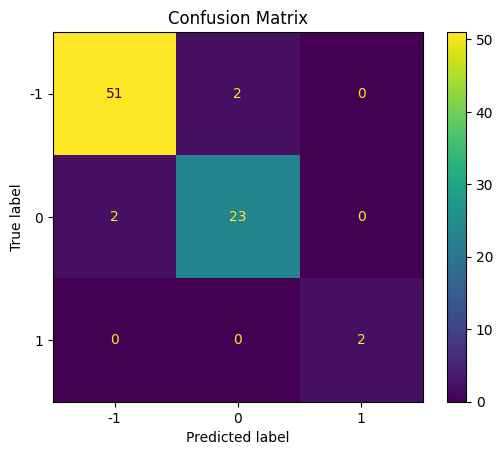

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=[-1, 0, 1])
plt.title("Confusion Matrix")
plt.show()

 4. **OPTUNA + CLASS WEIGHTS**

In [ ]:
# Разделение на признаки и цель
X = df.drop(['effect', 'effect_score', 'well_num', 'inj_well_id'], axis = 1)
y = df['effect']

In [ ]:
# Категориальные признаки
cat_features = ['breakthrough_time_cat', 'high_tracer_output', 'strong_hydro_conn',
                'cat_watercut', 'cat_speed', 'cat_volume', 'cat_area']

In [ ]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

Class Weights: {np.int64(-1): np.float64(0.5025252525252525), np.int64(0): np.float64(1.0698924731182795), np.int64(1): np.float64(13.266666666666667)}


In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=18
)

In [ ]:
def objective(trial):
    # Доп. разбиение train -> train/val внутри каждого триала
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, stratify=y_train, test_size=0.2, random_state=trial.number
    )

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 300),
        "random_state": 18,
        "verbose": 0,
        "cat_features": cat_features,
        "class_weights": class_weights
    }

    model = CatBoostClassifier(**params)
    model.fit(
        X_train_split, y_train_split,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=0
    )

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="macro")

In [ ]:
#Запускаем подбор
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-04-20 16:00:04,189] A new study created in memory with name: no-name-d6a202b4-beee-4038-9a67-159dae7dc91e
[I 2025-04-20 16:00:04,635] Trial 0 finished with value: 0.9875314228255405 and parameters: {'learning_rate': 0.14266195777102653, 'max_depth': 4, 'l2_leaf_reg': 2.4516390742745484, 'iterations': 226}. Best is trial 0 with value: 0.9875314228255405.
[I 2025-04-20 16:00:04,925] Trial 1 finished with value: 0.9875314228255405 and parameters: {'learning_rate': 0.1134883066529945, 'max_depth': 3, 'l2_leaf_reg': 6.30067049865501, 'iterations': 158}. Best is trial 0 with value: 0.9875314228255405.
[I 2025-04-20 16:00:08,775] Trial 2 finished with value: 0.9878538544421588 and parameters: {'learning_rate': 0.18731818731597372, 'max_depth': 6, 'l2_leaf_reg': 9.427422616854507, 'iterations': 272}. Best is trial 2 with value: 0.9878538544421588.
[I 2025-04-20 16:00:09,190] Trial 3 finished with value: 1.0 and parameters: {'learning_rate': 0.10944039803469852, 'max_depth': 4, 'l2_leaf

In [ ]:
# Лучшие параметры
print("Best parameters:", study.best_trial.params)

Best parameters: {'learning_rate': 0.10944039803469852, 'max_depth': 4, 'l2_leaf_reg': 1.8389822847701858, 'iterations': 143}


In [ ]:
# Обучим модель на лучших параметрах
final_model = CatBoostClassifier(
    **study.best_trial.params,
    cat_features=cat_features,
    class_weights=class_weights,
    random_state=42,
    verbose=100
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_holdout, y_holdout),
    early_stopping_rounds=50
)

0:	learn: 0.9192108	test: 0.9297642	best: 0.9297642 (0)	total: 3.06ms	remaining: 434ms
100:	learn: 0.0168802	test: 0.0848765	best: 0.0847211 (99)	total: 277ms	remaining: 115ms
142:	learn: 0.0106809	test: 0.0827759	best: 0.0821744 (124)	total: 398ms	remaining: 0us

bestTest = 0.08217440639
bestIteration = 124

Shrink model to first 125 iterations.


In [ ]:
# Оценим на тесте
y_pred = final_model.predict(X_holdout)
print(classification_report(y_holdout, y_pred))

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98        53
           0       0.96      0.96      0.96        25
           1       1.00      1.00      1.00         2

    accuracy                           0.97        80
   macro avg       0.98      0.98      0.98        80
weighted avg       0.97      0.97      0.97        80



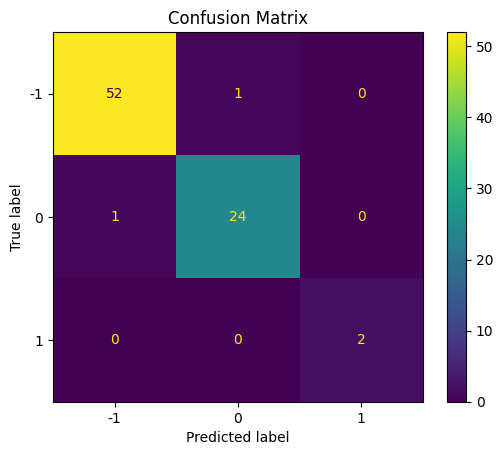

In [ ]:
ConfusionMatrixDisplay.from_estimator(final_model, X_holdout, y_holdout, display_labels=[-1, 0, 1])
plt.title("Confusion Matrix")
plt.show()